In [95]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.signal import butter, filtfilt
import os


In [ ]:

# change to your working directory
os.chdir(r'C:\Users\klilasulin\Dropbox\brain on a chip\Human brain organoids article\EMChip_paper_analysis_git')
os.getcwd()
# 

'C:\\Users\\klilasulin\\Dropbox\\brain on a chip\\Human brain organoids article\\EMChip_paper_analysis_git'

In [34]:
# ------ Hyperparameters ------ #
sampling_rate = 200 # in Hz

In [89]:
exp_dict = {'LFP_baseline': {'start_sec': 110 , 'stop_sec': 130, 'file_path': 'data/Raw_LFP_signals_example/baseline1_OpenBCI-RAW-2025-01-05_17-16-53.txt'},
            'LFP_TTX':{'start_sec': 27 , 'stop_sec': 47, 'file_path': 'data/Raw_LFP_signals_example/ttx2_OpenBCI-RAW-2025-01-05_18-14-31.txt'} ,
            'O2_baseline': {'start_sec': 110 , 'stop_sec': 130, 'file_path': 'data/Raw_O2_signals_example/baseline1.txt'},
            'O2_TTX': {'start_sec': 27 , 'stop_sec': 47, 'file_path': 'data/Raw_O2_signals_example/ttx2.txt'}}

In [76]:

def create_lfp_df(file_name: str, sampling_rate: int, chan: str, start_sec: int, stop_sec: int) -> pd.DataFrame:
    """
    Reads a CSV file, keeps only 'time' and the specified 'chan' columns,
    and splits the result into 5-minute chunks based on the time column.

    :param file_name: Path to the CSV file.
    :param sampling_rate: Number of samples per second (used only to create the 'time' column
                          if the file does not already contain one).
    :param chan: The channel/column to keep in addition to 'time'.
    :return: A list of DataFrames, each corresponding to a 5-minute segment (300 seconds).
    """

    # Read the CSV file
    df = pd.read_csv(
        file_name,
        header=4,      # adjust if needed
        sep=', ',
        on_bad_lines='skip',
        engine='python'
    )

    # Create 'time' column using DataFrame index / sampling_rate (if needed)
    # If your CSV already has a 'time' column in seconds, you could skip this step
    row_indexes = np.array(df.index.tolist())
    df['time'] = row_indexes / sampling_rate

    # Keep only 'time' and the specified channel
    df = df[['time', chan]]

    df = df[(df['time'] >= start_sec) & (df['time'] <= stop_sec)]
    df['time'] = df['time'].values - start_sec
    df.rename(columns={chan: 'lfp'}, inplace=True)



   

    return df


In [66]:



def create_o2_df(file_path: str, start_sec: int, stop_sec: int) -> pd.DataFrame:
    """
    Reads an O2 data file and returns a DataFrame with 'time' and 'o2' columns.
    Skips the first 6 metadata lines.
    Assumes each subsequent line has two tab-separated columns: time_in_seconds and o2_value.
    """
    time_data = []
    o2_data = []

    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
        lines = f.readlines()

    # Skip metadata lines (the snippet shows ignoring the first 6 lines)
    for i in range(6, len(lines)):
        fields = lines[i].strip().split('\t')
        if len(fields) < 2:
            continue
        try:
            t = float(fields[0])
            o2_val = float(fields[1])
            time_data.append(t)
            o2_data.append(o2_val)
        except ValueError:
            continue

    df = pd.DataFrame({'time': time_data, 'o2': o2_data})
    df = df[(df['time'] >= start_sec) & (df['time'] <= stop_sec)]
    df['time'] = df['time'].values - start_sec


    return df


In [91]:
for exp_name, params in exp_dict.items():
    if 'LFP' in exp_name:
        file_path = params['file_path']
        lfp_df = create_lfp_df(file_path, sampling_rate, 'EXG Channel 0', params['start_sec'], params['stop_sec'])
        # add lfp_dfs to exp_dict
        exp_dict[exp_name]['data_df'] = lfp_df
        
    elif 'O2' in exp_name:
        file_path = params['file_path']
        o2_df = create_o2_df(file_path, params['start_sec'], params['stop_sec'])
        # add o2_dfs to exp_dict
        exp_dict[exp_name]['data_df'] = o2_df



In [93]:

def plot_lfp_signal(df, filter, sampling_rate, ylim_range, tick_range, title, line_weight=2):
    if filter:
        lowcut = 0.5  # Low cut frequency in Hz
        highcut = 40  # High cut frequency in Hz

        nyq = 0.5 * sampling_rate  # Nyquist Frequency
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(N=2, Wn=[low, high], btype='band')

        # Apply the filter to the cropped signal
        data = filtfilt(b, a, df['lfp'])
        df = pd.DataFrame({'time': df['time'], 'lfp': data})

    time = np.array(df['time'])

    # Adjust time array if necessary
    if time[0] > 1:
        time = time - time[0]
    data_array = df['lfp'].values    

    plt.figure(figsize=(6, 3), dpi=300)  # High resolution suitable for an article
    # plt.figure(figsize=(20,5))  # High resolution suitable for an article
    ax = plt.gca()  # Get current axis

    # Plot the data with controlled line weight
    plt.plot(time, data_array, color='darkred', linewidth=line_weight)

    # Title, labels, and sizes
    plt.xlabel("Time (s)", fontsize=26)
    # plt.xticks(fontsize=22)
    plt.xticks(np.arange(0, 21, 5), fontsize=22)

    plt.ylim(-ylim_range, ylim_range)

    # plot ticks with spacing of tick_range in y-axis
    plt.yticks(np.arange(-ylim_range, ylim_range + 1, tick_range))
    plt.ylabel("Voltage(uV)", fontsize=26)
    plt.yticks(fontsize=22)
    # Set visibility of axis spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Removing grid lines
    ax.set_axisbelow(True)
    ax.xaxis.grid(False)  # Disable x-axis grid lines
    ax.yaxis.grid(False)  # Disable y-axis grid lines
    plt.xlim(0, 20)
    plt.title(title, fontsize=28)

    plt.show()



def plot_o2_signal(df, ylim_range, tick_range, title, line_weight=2):   
    # same for o2 signal
    time = np.array(df['time'])
    data_array = df['o2'].values
    time = time - time[0]

    # plt.figure(figsize=(20,5))  # High resolution suitable for an article
    plt.figure(figsize=(6, 3), dpi=300)  # High resolution suitable for an article
    ax = plt.gca()  # Get current axis
    plt.plot(time, data_array, linewidth=line_weight)
    plt.xlabel("Time (s)", fontsize=26)
    plt.xlim(0, 20)
    plt.xticks(np.arange(0, 21, 5), fontsize=22)
    # plt.xticks(fontsize=22)
    plt.ylim(ylim_range[0], ylim_range[1])
   
    plt.ylabel("Oxygen(% Air)", fontsize=26)
    plt.yticks(fontsize=22)
    # plot ticks with spacing of tick_range in y-axis
    plt.yticks(np.arange(ylim_range[0], ylim_range[1]+1, 20))
    # Set visibility of axis spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(title, fontsize=28)

    plt.show()



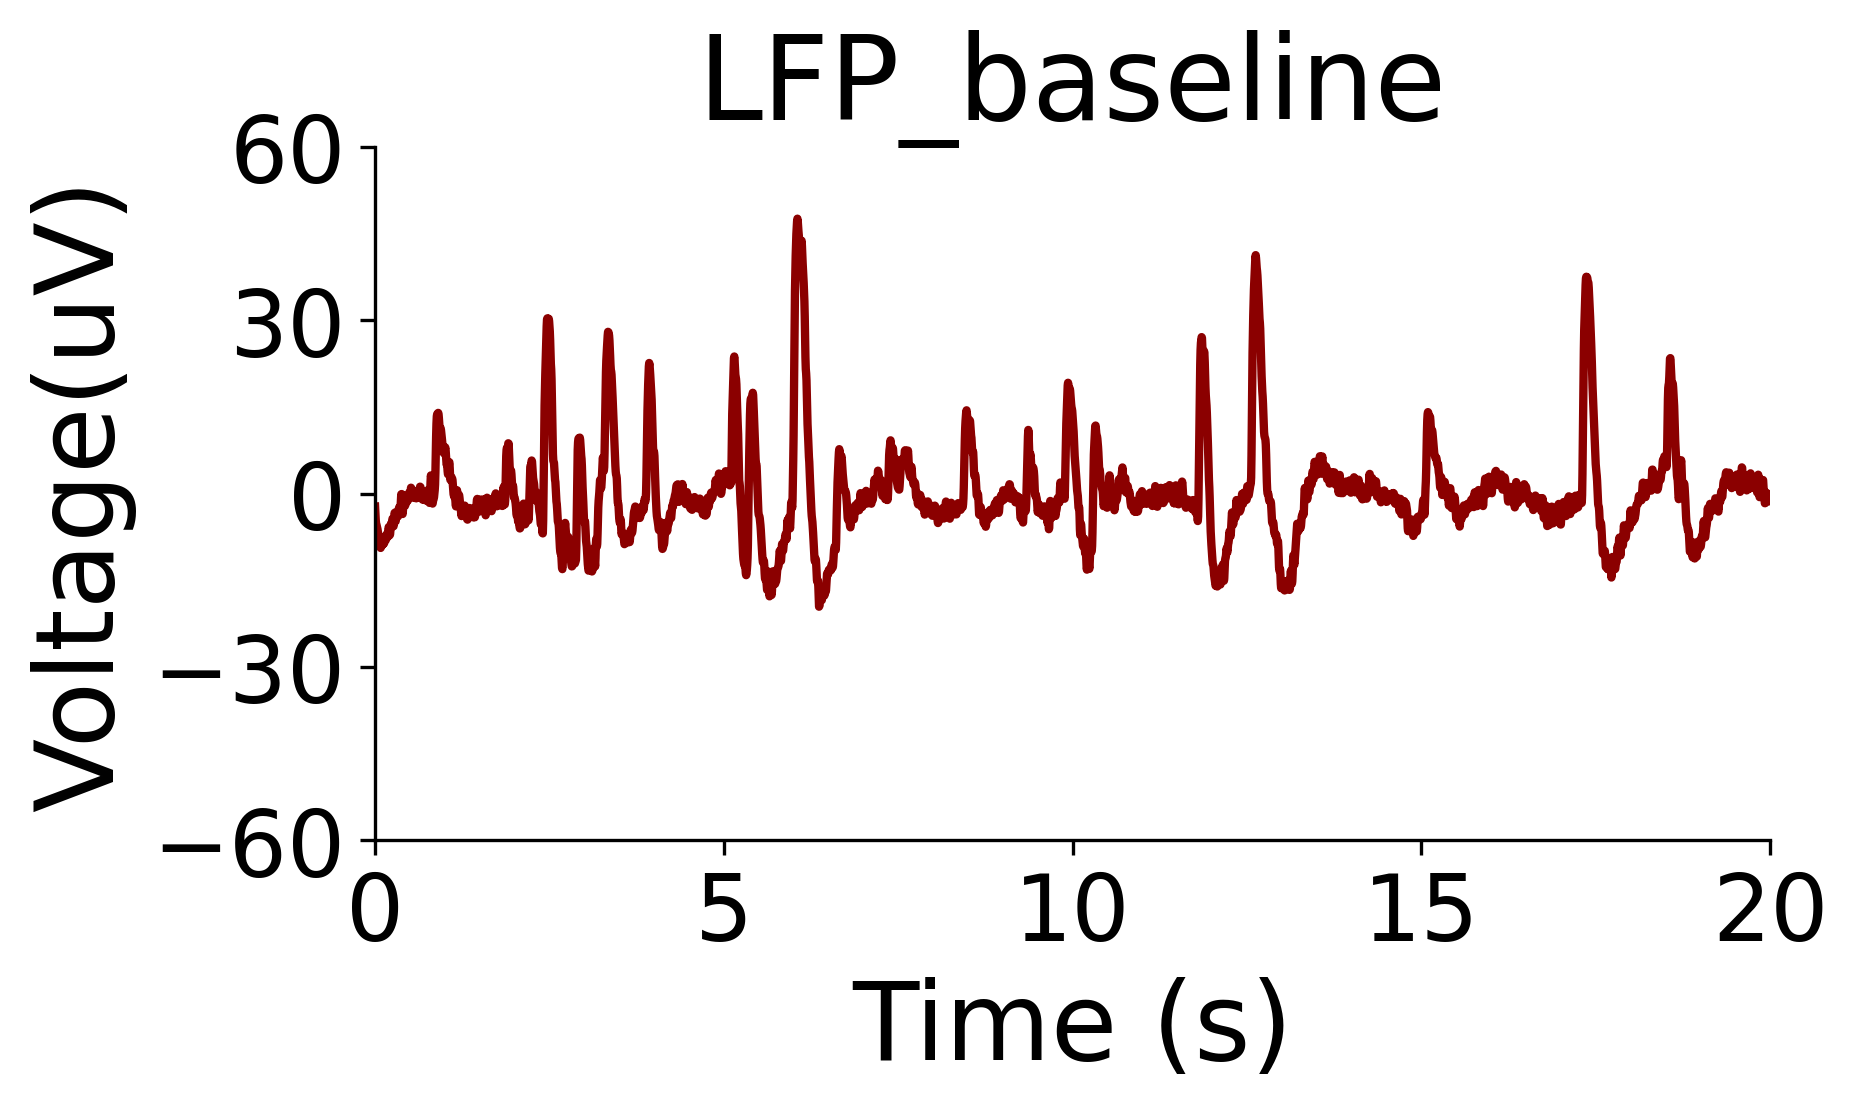

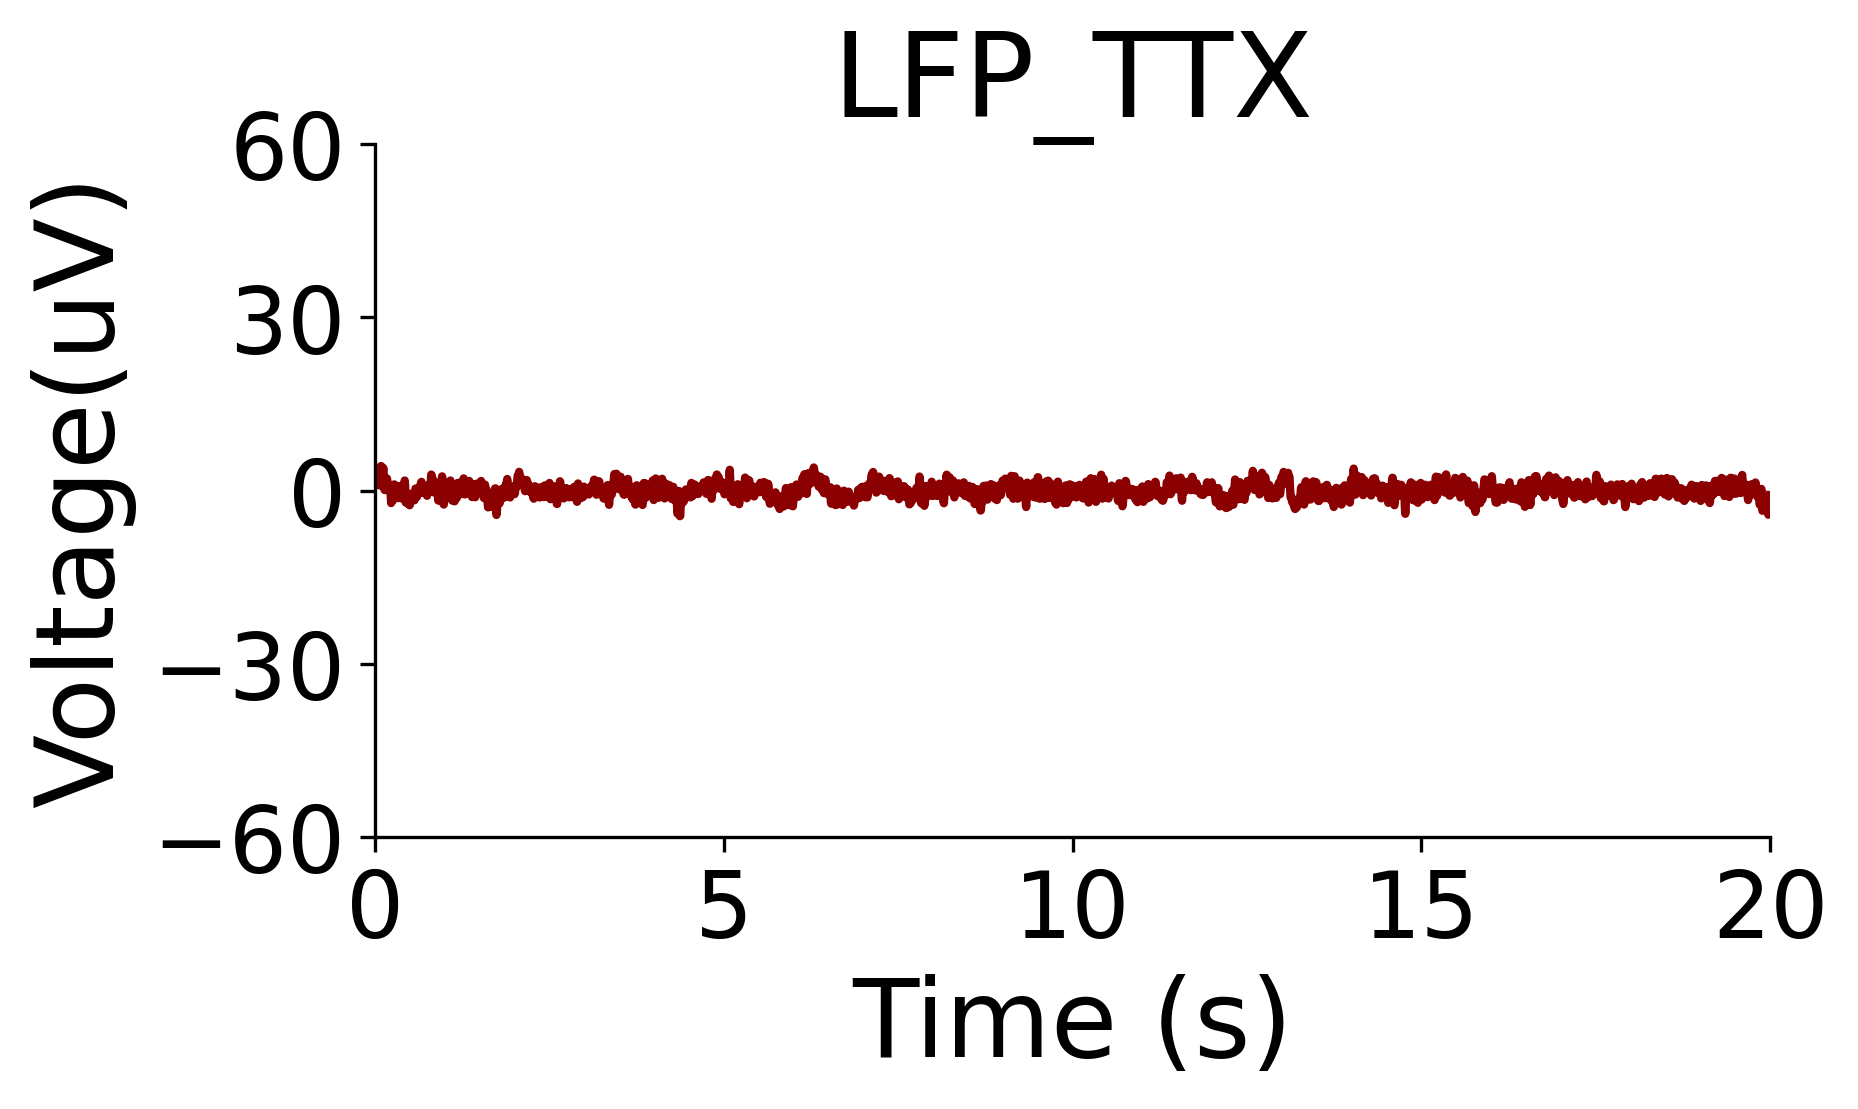

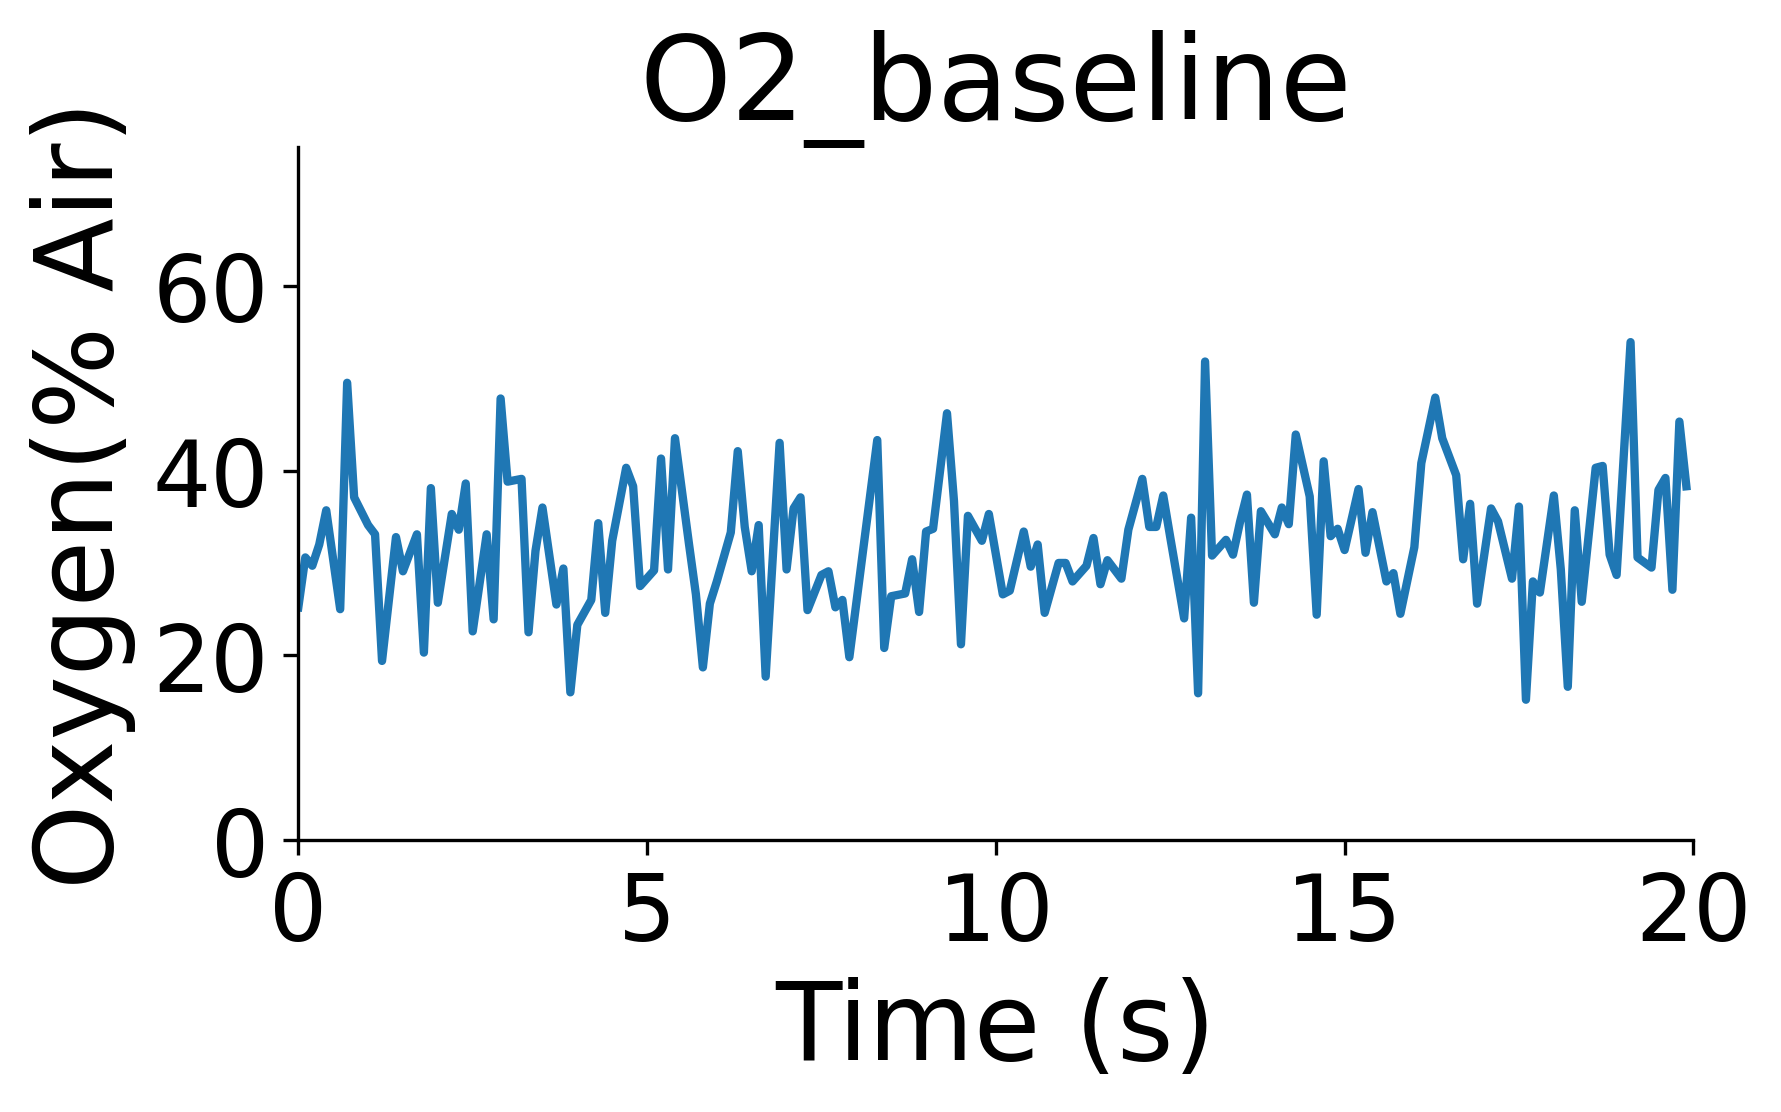

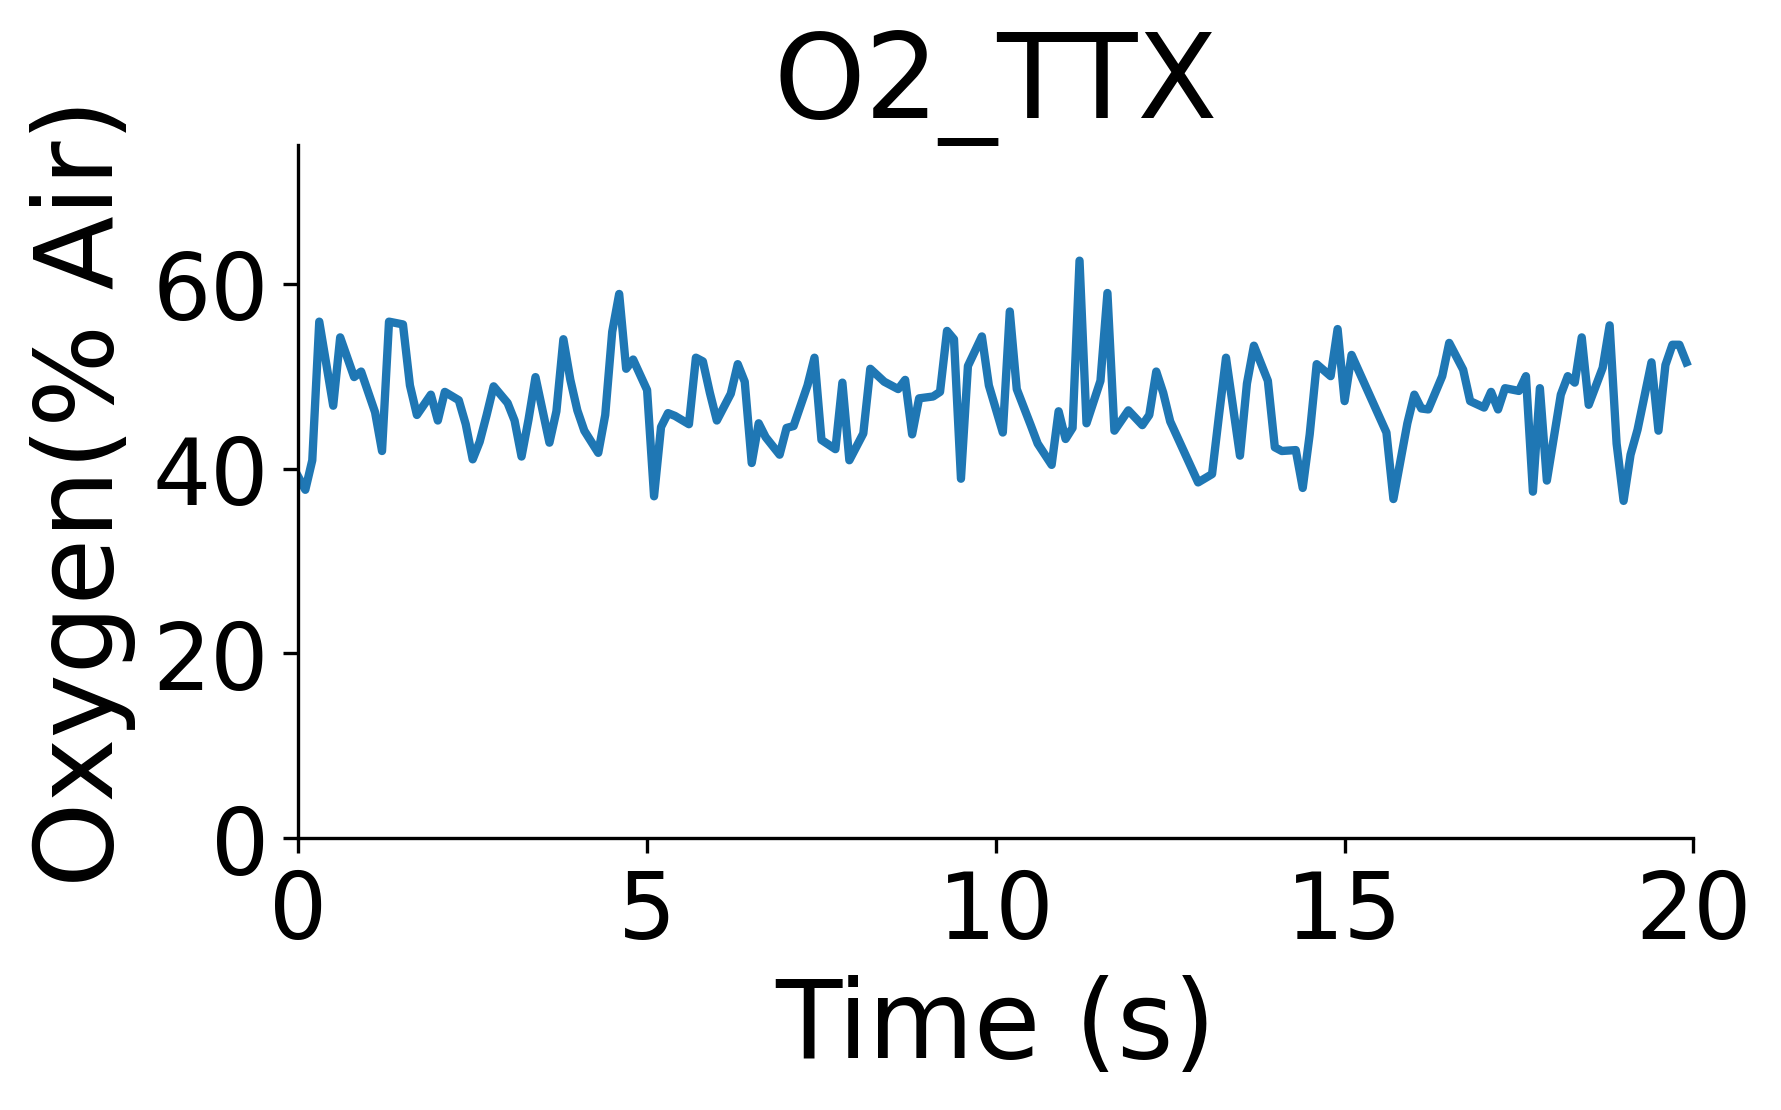

In [94]:
for exp_name, params in exp_dict.items():
    if 'LFP' in exp_name:
        plot_lfp_signal(params['data_df'], 
                    filter=True, 
                    sampling_rate=sampling_rate, 
                    ylim_range=60, 
                    tick_range=30,
                    title = exp_name, 
                    line_weight=2)
    elif 'O2' in exp_name:
        plot_o2_signal(params['data_df'], 
                    ylim_range=(0, 75), 
                    tick_range=20, 
                    title = exp_name,
                    line_weight=2)
